# Analysis code supporting blah

This notebook uses data downloaded in the `download_extract_data` notebook to predict $CV[S_0]$ for the two study sites, Elder Creek and Dry Creek. $CV[ET_{dry}]$ is then calculated from remotely sensed data and used to infer $S_{max}$ at the sites. 

In [52]:
%matplotlib inline
import os
import sys
from os.path import dirname
from matplotlib import pyplot as plt
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
import numpy as np
import seaborn as sns
import pandas as pd
import scipy
from tqdm import tqdm
import matplotlib.dates as mdates
import evaplib as evap
import meteolib as meteo
import glob
import datetime
import geopandas as gp
import multiprocessing as mp
import matplotlib.gridspec as gridspec
def gamma_porp(a,b):
    from scipy import special
    return special.gamma(a)-special.gamma(a)*special.gammainc(a,b)

# Helper functions

In [2]:
# Rainfall interception function
def intercept_rain_daily(ppt, interception_depth):
    '''
        Simple function to intercept rainfall from veg
        inputs: 
            ppt - daily frequency precipitation pandas Series object 
            interception_depth - value in same units as precip to intercept
            from daily precip events
        outputs: 
            ppt dataframe less the intercepted volumes
    '''
    return ppt.apply(lambda val: np.max([val-interception_depth, 0]))

def run_chunk(arguments):
    '''
        Monte Carlo simulation code for predicting CV[S0]
        inputs: 
            arguments - list or tuple with 
    '''
    LAM, Smax, alpha, dt, tw, pet, num_sims, cpu = arguments        
    t = np.linspace(0,tw,int(np.ceil(tw/dt)))
    CV = np.zeros_like(LAM)
    for i in range(len(LAM)):
        lam, smax = LAM[i], Smax[i]
        S = np.zeros((num_sims, len(t)))
        for num in range(num_sims): 
            rainfall = np.array([np.random.exponential(alpha) if np.random.uniform() > np.exp(-lam*dt) else 0.0 for i in range(len(t))])
            storage = np.zeros_like(rainfall)
            for idx in range(len(rainfall)-1):
                dstorage = rainfall[idx] - pet*storage[idx]/smax*dt
                storage[idx+1] = storage[idx] + dstorage
                storage[idx+1] = np.min([storage[idx+1], smax])
            S[num,:] = storage
        CV[i] = np.std(S[:,-1])/np.mean(S[:,-1])
    return (CV, cpu)

def zero_runs(a):
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges


def get_precip_stats(ppt, clustered=True, interception_depth=0, doystart=275, doyend=140, loud=True):
    ppt = intercept_rain_daily(ppt, interception_depth)
    if doystart>doyend:
        wet_season = ppt[(ppt.index.dayofyear>=doystart)|(ppt.index.dayofyear<=doyend)].ffill().values
    else: 
        wet_season = ppt[(ppt.index.month>=doystart)&(ppt.index.month<=doyend)].ffill().values
    
    # Normal rainfall stats
    lam = len(wet_season[wet_season>0])/float(len(wet_season))
    alpha = np.mean(wet_season[wet_season>0])
    
    # Calculate clustered stats
    runs = zero_runs(wet_season<=0)
    lam_clustered = len(runs)/float(len(wet_season))
    alpha_clustered = np.nanmean(np.array( [np.sum(wet_season[idx[0]:idx[1]]) for idx in runs]))
    if clustered: 
        lam = lam_clustered
        alpha = alpha_clustered
    if loud:
        print('Rainfall frequency = %.3f per day, mean event depth = %.f mm'%(lam, alpha))
    return lam, alpha

# Determine start/end of wet season

Length of wet season is 224 days


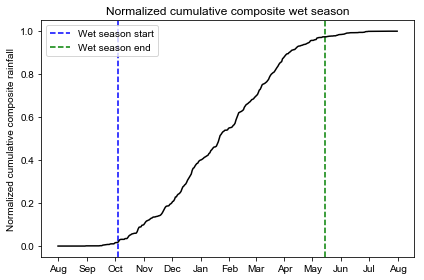

In [58]:
ppt = pd.read_csv('../data/elder_ppt.csv', parse_dates=True, index_col=0).ppt*1000
ppt = ppt.resample('D').mean()

midsummer = 210
ppt_dowy = pd.DataFrame(ppt.values, index=ppt.index, columns=['ppt'])
ppt_dowy['dowy'] = ppt_dowy.index.dayofyear - midsummer
ppt_dowy.loc[ppt_dowy.dowy<=0, 'dowy'] += 365
pptdowy = ppt_dowy.groupby('dowy').sum()
maxval = pptdowy.cumsum().iloc[-1]
normalized = pptdowy.cumsum()/maxval
percentage = 2.5
wetstart = pd.to_timedelta(midsummer + np.where(normalized>percentage/100.0)[0][0],unit='day') + pd.to_datetime('2018-01-01')
wetend = pd.to_timedelta(midsummer + np.where(normalized>(100-percentage)/100.0)[0][0],unit='day') + pd.to_datetime('2018-01-01')
doystart = wetstart.dayofyear
doyend = wetend.dayofyear

# Wet season start and end months
tw = len(pd.date_range(wetstart, wetend))

# PET data from download_extract_data notebook
pet_df = pd.read_csv('../data/elder_dry_pet.csv', parse_dates=True, index_col=0)
pet_winter = pet_df.loc[(pet_df.index.dayofyear>=doystart)|(pet_df.index.dayofyear<=doyend)].mean()
pet = float(pet_winter['Elder Creek'])
print('Length of wet season is %d days'%tw)


oneyear = pd.date_range('2018-08-01', '2019-07-31')
plt.plot(oneyear, normalized,'k')
plt.title('Normalized cumulative composite wet season')
plt.ylabel('Normalized cumulative composite rainfall')
plt.vlines(wetstart, -0.05,1.05,colors='b', linestyles='dashed', label='Wet season start')
plt.vlines(wetend, -0.05,1.05,colors='g', linestyles='dashed', label='Wet season end')

# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')

X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)

plt.legend()
plt.ylim([-0.05,1.05])
plt.tight_layout()

In [8]:
print('Calculated with ERCZO rainfall data...')
lam, alpha = get_precip_stats(ppt, interception_depth=4.0, clustered=True, doystart=doystart, doyend=doyend,loud=True)
print('\n')

prism_ppt = pd.read_csv('../data/elder_dry_prism_ppt.csv', header=[0,1],parse_dates=True, index_col=0)
print('Calculated with PRISM...')
prism_lam, prism_alpha = get_precip_stats(prism_ppt[('ppt', 'Elder Creek')].loc['2008':'2018'], clustered=True, interception_depth=4.0, doystart=doystart, doyend=doyend,loud=True)

Calculated with ERCZO rainfall data...
Rainfall frequency = 0.115 per day, mean event depth = 66 mm


Calculated with PRISM...
Rainfall frequency = 0.108 per day, mean event depth = 73 mm


# Load and calculate CV[${ET}_{dry}$]

In [9]:
ets = pd.read_csv('../data/elder_dry_et.csv', index_col=0, parse_dates=True)
summerstart = 6
summerend = 8
summers = ets.loc[(ets.index.month>=summerstart)&(ets.index.month<=summerend)]
summer_ets = summers.groupby(summers.index.year).sum()
etcvs = summer_ets.std()/summer_ets.mean()

# Run Monte Carlo simulations to setup inversion
Using rainfall statistics ($\lambda$ and $\alpha$, wet season length ($T_w$), and average wet season potential evapotranspiration (PET), we can solve the stochastic model for the coefficient of variation of end-wet-season storage as a function of storage capacity. 

Do not run this script unless necessary; it takes several hours to complete on an average laptop computer. Calculated CV data is already stored in the `../data` folder

There are 4 cores


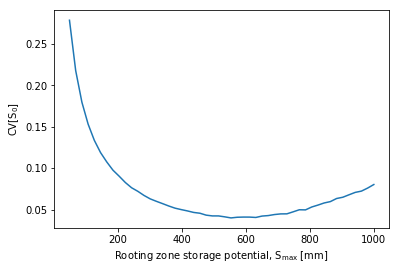

In [51]:
num_sims = 50000
cores = mp.cpu_count()
sys.stdout.write('There are %s cores'%(cores) + '\r\n')

dt = 0.1

# Choose ranges to simulate for Smax and lambda
# np.linspace(lam, lam, 1) could be replaced with 
# np.linspace(lam_min, lam_max, dlam) to simulate more than 
# one value of lambda. The code is setup to run in parallel
# so can simulate for many locations at once.
# Here we just run the simulation for a single lambda
smaxlower = 50
smaxupper = 1000
dS = 50
Smax = np.linspace(smaxlower, smaxupper, dS)
LAM = np.linspace(lam, lam, 1)
X,Y = np.meshgrid(LAM, Smax)
Xs, Ys = np.array_split(X,cores), np.array_split(Y, cores)
args = [(Xs[i], Ys[i], alpha, dt, tw, pet, num_sims, range(cores)[i]) for i in range(len(Xs))]

# processor pool to parallelize task
pool = mp.Pool()
results = pool.map(run_chunk, args)
CVS_list = [0 for i in range(len(Xs))]
for result in results:
     CVS_list[result[1]] = result[0]

# cleanup
pool.close()
pool.terminate()

# concatenate all computed cvs
CVS = np.concatenate(CVS_list)

# if only simulated a single lambda value
if np.shape(X)[1]==1:
    y = Y.flatten()
    cvs = CVS.flatten()
    f,ax = plt.subplots(1, figsize=(6,4))
    ax.plot(y, cvs)
    ax.set_xlabel('Rooting zone storage potential, $\mathrm{S_{max}}$ [mm]')
    ax.set_ylabel('CV[S$_0$]')
    np.save('../data/cvs_dry_elder_%d_%d_%d.npy'%(smaxlower, smaxupper, dS), cvs)
else: # if explored many values of lambda, make contour plot
    # could edit this to save data
    plt.contourf(X,Y,CVS)
    plt.xlabel('Storm frequency [events per day]')
    plt.ylabel('Storage capacity [mm]')
    plt.title('Dry season storage sensitivity\nto climate and storage capacity')
    cb = plt.colorbar()
    cb.set_label('CV conditions @ dry season start ')

# Plot CV as a function of storage capacity

Plot  results from the monte carlo simulation (black line) and map the two sites onto their respective storage capacities under the assumption that $CV[S_0] = CV[{ET}_{dry}]$.

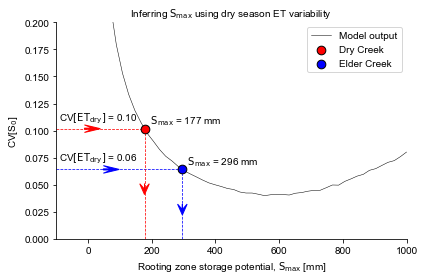

In [10]:
plotranges = False

# Get CV[S0] values from Monte Carlo sims
fn = '../data/cvs_dry_elder_50_1000_50.npy'
cvs = np.load(fn)
smaxupper = int(fn.split('.')[-2].split('_')[-2])
smaxlower = int(fn.split('.')[-2].split('_')[-3])
dS = int(fn.split('.')[-2].split('_')[-1])
Smax = np.linspace(smaxlower, smaxupper, dS)

# Grab CV[ETdry] for Elder and Dry Creek
drymax= etcvs['Dry Creek']
eldermax = etcvs['Elder Creek']

# Find Smax value where CV[ETdry] intersects theoretical curve
idx = np.where(np.diff((cvs-drymax)>0)==1)[0][0]
cvleft = cvs[idx]
cvright = cvs[idx+1]
frac = (drymax - cvleft)/(cvright - cvleft)
drymax_storage = Smax[idx] + frac*(Smax[idx+1] - Smax[idx])

idx = np.where(np.diff((cvs-eldermax)>0)==1)[0][0]
cvleft = cvs[idx]
cvright = cvs[idx+1]
frac = (eldermax - cvleft)/(cvright - cvleft)
eldermax_storage = Smax[idx] + frac*(Smax[idx+1] - Smax[idx])

# Plot it up!
f,ax = plt.subplots(1,figsize=(6.,4.))

# Plot theoretical curve
line1, = plt.plot(Smax,cvs, 'k', lw=0.5,)
label1='Model output'

# Dry Creek intersection with model curve
line2 = plt.scatter(drymax_storage, drymax, c='r', s=75, zorder=10,  edgecolors='k')
label2 = 'Dry Creek'

# Elder Creek intersection with model curve
line3 = plt.scatter(eldermax_storage, eldermax, c='b', s=75, zorder=10,edgecolors='k')
label3 = 'Elder Creek'

# TODO: make arrows corresponding to steps in manuscript
ax.plot([-100,eldermax_storage], [eldermax, eldermax],'--', c='b', lw=0.75)
ax.plot([eldermax_storage,eldermax_storage], [0, eldermax],'--', c='b', lw=0.75)
ax.plot([-100,drymax_storage], [drymax, drymax],'--', c='r', lw=0.75)
ax.plot([drymax_storage,drymax_storage], [0, drymax],'--', c='r', lw=0.75)
ax.annotate('CV$[\mathrm{ET}_\mathrm{dry}]$ = ' + '%.2f'%(drymax), (-90, drymax+.008))
ax.annotate('CV$[\mathrm{ET}_\mathrm{dry}]$ = ' + '%.2f'%(eldermax), (-90, eldermax+.008))
ax.text(eldermax_storage, eldermax+.005,'  $\mathrm{S_{max}}$ = ' + '%.0f mm'%(eldermax_storage))
ax.text(drymax_storage, drymax+.005,'  $\mathrm{S_{max}}$ = ' + '%.0f mm'%(drymax_storage))
ax.set_xlabel('Rooting zone storage potential, $\mathrm{S_{max}}$ [mm]')
ax.set_ylabel('CV[S$_0$]')
titlestr = 'Inferring $\mathrm{S_{max}}$ using dry season ET variability'
ax.set_title(titlestr, fontsize=10)
ax.set_ylim([0,0.2])
ax.set_xlim([-100,1000])

# If you want to plot observed ranges for Smax on the plot
if plotranges:
    line4, = ax.plot([150, 200], [0.001,0.001], c='r', lw=6, )
    label4 = 'Observed range $\mathrm{S_{max}}$'
    line5, = ax.plot([320, 430], [0.001,0.001], c='b', lw=6,)
    label5 = 'Observed range $\mathrm{S_{max}}$'
    plt.legend([line1, line2, line4, line3, line5], [label1, label2, label4, label3, label5])
else: # otherwise just show the inversion step
    plt.legend([line1, line2,  line3, ], [label1, label2,  label3, ])

# inversion arrows
ax.arrow(drymax_storage-drymax_storage/2-100,drymax,50 ,0, length_includes_head=True,head_width=0.007, head_length=50, ec='r',fc='r', overhang=0.5)
ax.arrow(eldermax_storage-eldermax_storage/2-100,eldermax,50 ,0, length_includes_head=True,head_width=0.007, head_length=50, ec='b',fc='b', overhang=0.5)
ax.arrow(drymax_storage, drymax/2.0, 0, -0.01,length_includes_head=True,head_width=30, head_length=0.01, ec='r',fc='r', overhang=0.5)
ax.arrow(eldermax_storage, eldermax/2.0, 0, -0.01,length_includes_head=True,head_width=30, head_length=0.01, ec='b',fc='b', overhang=0.5)

plt.tight_layout()
sns.despine()
plt.savefig('../plots/cv_end_mc_elderppt_ETdryseason.pdf')

Spring spearman rho = 0.07, spring p-value = 0.79
Whole wet season spearman rho = -0.38, whole wet season p-value = 0.13
Spring spearman rho = 0.43, spring p-value = 0.08
Whole wet season spearman rho = 0.09, whole wet season p-value = 0.74


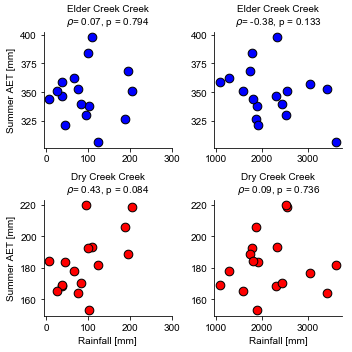

In [74]:
startyear = ppt.index[0].year
f, axs = plt.subplots(2,2, figsize=(5,5))

ppt_resolve = prism_ppt[('ppt', 'Elder Creek')]
for j,catchment in enumerate(['Elder Creek', 'Dry Creek']):
    summerets = []
    totalP = []
    springP = []
    yearlist = []

    for g in summer_ets.groupby(summer_ets.index):
        
        summerdf = g[1]
        year = g[0]
        if year not in ppt_resolve.index.year.unique()[1:]:
            continue
        wetstart = pd.to_datetime(str(year-1) + '-01-01') + pd.to_timedelta(doystart, unit='D')
        wetend = pd.to_datetime(str(year) + '-01-01') + pd.to_timedelta(doyend, unit='D')
        yearlist.append(year)
        springstart = wetend - pd.to_timedelta(30, unit='D')
        totalP.append(np.nansum(ppt_resolve.loc[(ppt_resolve.index>=wetstart)&(ppt_resolve.index<=wetend)].values))
        springP.append(np.nansum(ppt_resolve.loc[(ppt_resolve.index>=springstart)&(ppt_resolve.index<=wetend)].values))
        summerets.append(summerdf[catchment].sum())
    
    spring_corr, spring_p = scipy.stats.spearmanr(springP, summerets)
    print('Spring spearman rho = %.2f, spring p-value = %.2f'%(spring_corr, spring_p))
    whole_corr, whole_p = scipy.stats.spearmanr(totalP, summerets)
    print('Whole wet season spearman rho = %.2f, whole wet season p-value = %.2f'%(whole_corr, whole_p))

    
    ax = axs[j,0]
    anostr = r'$\rho$' + '= %.2f, p = %.3f'%(spring_corr, spring_p)
    if j==0:
        ax.scatter(springP, summerets, c='b', edgecolors='k', s=75)
    else:
        ax.scatter(springP, summerets, c='r', edgecolors='k', s=75)


    ax.set_xlim([-5,300])
    titlestr = catchment.split('.')[0] + ' Creek\n'
    ax.set_title(titlestr.title() + anostr, fontsize=10)
    if j==1:
        ax.set_xlabel('Rainfall [mm]')
    ax.set_ylabel('Summer AET [mm]')

    ax = axs[j,1]
    anostr = r'$\rho$' + '= %.2f, p = %.3f'%(whole_corr, whole_p)
    if j==0:
        ax.scatter(totalP, summerets, c='b', edgecolors='k', s=75)
    else:
        ax.scatter(totalP, summerets, c='r', edgecolors='k', s=75)

#     ax.set_ylim([100,800])
    titlestr = catchment.split('.')[0] + ' Creek\n'
    ax.set_title(titlestr.title() + anostr,fontsize=10)
    if j==1:
        ax.set_xlabel('Rainfall [mm]')

sns.despine(fig=f)
f.tight_layout()
f.savefig('../plots/resolve_inversion.pdf')

Spring spearman rho = 0.07, spring p-value = 0.79
Whole wet season spearman rho = -0.38, whole wet season p-value = 0.13
Spring spearman rho = 0.43, spring p-value = 0.08
Whole wet season spearman rho = 0.09, whole wet season p-value = 0.74


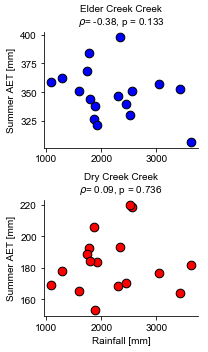

In [76]:
startyear = ppt.index[0].year
f, axs = plt.subplots(2,1, figsize=(3,5))

ppt_resolve = prism_ppt[('ppt', 'Elder Creek')]
for j,catchment in enumerate(['Elder Creek', 'Dry Creek']):
    summerets = []
    totalP = []
    springP = []
    yearlist = []

    for g in summer_ets.groupby(summer_ets.index):
        
        summerdf = g[1]
        year = g[0]
        if year not in ppt_resolve.index.year.unique()[1:]:
            continue
        wetstart = pd.to_datetime(str(year-1) + '-01-01') + pd.to_timedelta(doystart, unit='D')
        wetend = pd.to_datetime(str(year) + '-01-01') + pd.to_timedelta(doyend, unit='D')
        yearlist.append(year)
        springstart = wetend - pd.to_timedelta(30, unit='D')
        totalP.append(np.nansum(ppt_resolve.loc[(ppt_resolve.index>=wetstart)&(ppt_resolve.index<=wetend)].values))
        springP.append(np.nansum(ppt_resolve.loc[(ppt_resolve.index>=springstart)&(ppt_resolve.index<=wetend)].values))
        summerets.append(summerdf[catchment].sum())
    
    spring_corr, spring_p = scipy.stats.spearmanr(springP, summerets)
    print('Spring spearman rho = %.2f, spring p-value = %.2f'%(spring_corr, spring_p))
    whole_corr, whole_p = scipy.stats.spearmanr(totalP, summerets)
    print('Whole wet season spearman rho = %.2f, whole wet season p-value = %.2f'%(whole_corr, whole_p))

    
#     anostr = r'$\rho$' + '= %.2f, p = %.3f'%(spring_corr, spring_p)
#     if j==0:
#         ax.scatter(springP, summerets, c='b', edgecolors='k', s=75)
#     else:
#         ax.scatter(springP, summerets, c='r', edgecolors='k', s=75)


#     ax.set_xlim([-5,300])
#     titlestr = catchment.split('.')[0] + ' Creek\n'
#     ax.set_title(titlestr.title() + anostr, fontsize=10)
#     if j==1:
#         ax.set_xlabel('Rainfall [mm]')
#     ax.set_ylabel('Summer AET [mm]')

    anostr = r'$\rho$' + '= %.2f, p = %.3f'%(whole_corr, whole_p)
    if j==0:
        ax = axs[j]
        ax.scatter(totalP, summerets, c='b', edgecolors='k', s=75)
    else:
        ax = axs[j]
        ax.scatter(totalP, summerets, c='r', edgecolors='k', s=75)

#     ax.set_ylim([100,800])
    titlestr = catchment.split('.')[0] + ' Creek\n'
    ax.set_title(titlestr.title() + anostr,fontsize=10)
    if j==1:
        ax.set_xlabel('Rainfall [mm]')
    ax.set_ylabel('Summer AET [mm]')

sns.despine(fig=f)
f.tight_layout()
f.savefig('../plots/resolve_inversion.pdf')

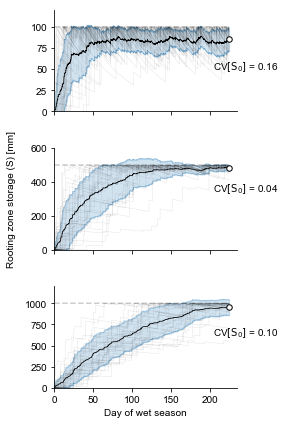

In [15]:
## try some wet season simulations against theory
from matplotlib import gridspec as gridspec
Smax = [100, 500, 1000]
pet = float(pet_winter['Elder Creek'])
dt = 0.1
wet_seasons = []
CV = []
rainfall_totals = []
for smax in Smax:       
    t = np.linspace(0,tw,int(np.ceil(tw/dt)))
    num_sims = 30
    S = np.zeros((num_sims, len(t)))
    for num in range(num_sims): 
        rainfall = np.array([np.random.exponential(alpha) if np.random.uniform() > np.exp(-lam*dt) else 0.0 for i in range(len(t))])
        storage = np.zeros_like(rainfall)
        for idx in range(len(rainfall)-1):
            dstorage = rainfall[idx] - pet*storage[idx]/smax*dt
            storage[idx+1] = storage[idx] + dstorage
            storage[idx+1] = np.min([storage[idx+1], smax])
        S[num,:] = storage
        rainfall_totals.append(np.sum(rainfall))
    wet_seasons.append(S)
    CV.append(np.std(S[:,-1])/np.mean(S[:,-1]))
    
fig, axs = plt.subplots(len(Smax), 1, figsize=(4, 2*len(Smax))) 

for i in range(len(axs)):
    X = wet_seasons[i]
    ax = axs[i]
    endS0 = np.mean(X,axis=0)[-1]
    ax.plot(t, np.mean(X,axis=0), label='Mean',zorder=10, c='k', lw=0.75)
    std = np.std(X, axis=0)
    upper = np.mean(X,axis=0) + std   
    lower = np.mean(X,axis=0) - std   
    ax.plot(t, upper, c='C0', lw=0.5, alpha=0.5)
    ax.plot(t, lower, c='C0', lw=0.5, alpha=0.5)
    ax.fill_between(t, lower, upper, color='C0', alpha=0.2)
    ax.plot(t,np.transpose(X),'k',lw=0.5, alpha=0.1, label='MC sims')
    titlestr = '%.0f mm storage potential'%(Smax[i])
    if ax==axs[-1]:
        ax.set_xlabel('Day of wet season')
    if ax!=axs[-1]:
        labs = ax.get_xticklabels()
        labs = ['' for i in range(len(labs))]
        ax.set_xticklabels(labs)
    w0max = np.ones_like(t)*Smax[i]
    ax.plot(t, w0max, '--k', alpha=0.2)
    cv = np.std(X[:,-1])/np.mean(X[:,-1])
#     ax.annotate('S$_\mathrm{max}$ = %.0f mm'%(Smax[i]), (1*tw/3,Smax[i]*1.05))
    ax.text(tw-20,endS0-std[-1]-int(endS0/4), r'CV$[\mathrm{S_{0}}]$ = ' + '%.2f'%cv)
    ax.scatter(tw,endS0, c='w',s=30, edgecolor='k', zorder=100)
    ax.set_ylim([0,Smax[i]+0.2*Smax[i]])
    ax.set_xlim([0,tw+10])
    sns.despine(ax=ax)

#     ax.annotate("}",
#             xy=(tw+10, upper[-1]), xycoords='data',
#             xytext=(tw+10, lower[-1]), textcoords='data',
#             arrowprops=dict(arrowstyle="<->", ec='k',shrinkA=0, shrinkB=0),
#                )
    
axs[1].set_ylabel('Rooting zone storage (S) [mm]\n')
fig.tight_layout()
fig.savefig('../plots/goldilocks.pdf')